# CIFAR‑10 with a Fully Connected Neural Network

**Lab 2: CIFAR‑10 Classification with a Fully Connected Neural Network**

**Weighting (Total 5%)**
- **In‑Lab (3 hours)** — *2%*: train a simple feedforward NN on CIFAR‑10, plot **training vs validation loss/accuracy**, compute a **confusion matrix**, and inspect **misclassifications**.
- **Take‑Home (1 week)** — *3%*: try small modifications (hidden size / activation / LR / epochs), update plots & metrics, and write a short 1–2 page report.

**Learning goals**
- Get comfortable with a new dataset (**CIFAR‑10**, 32×32 color images).
- Practice evaluating models beyond accuracy: curves, confusion matrix, qualitative errors.
- See limits of fully connected NNs on images (CNNs will follow in the next lab).

In [30]:
# ✅ Device setup (CPU/GPU)
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


Importing some required libraries. You can add more if needed.

In [31]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils
import numpy as np
import matplotlib.pyplot as plt

## PART A: In lab

1. Load the CIFAR-10 dataset. Load, normalize, create train/val/test splits. The trainset is shown for you.

Train size: 50000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


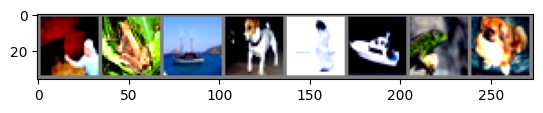

horse frog ship dog bird ship frog dog


In [32]:
# Transform: convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),                           # convert to tensor [0,1]
    transforms.Normalize((0.5, 0.5, 0.5),            # mean for R,G,B
                         (0.5, 0.5, 0.5))            # std for R,G,B
])

cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)

train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])


root = './data'
val_size = 5000
batch_size=256

full_train = datasets.CIFAR10(root, train=True, download=True, transform=train_tf)
train_size = len(full_train) - val_size
train_ds, val_ds = random_split(full_train, [train_size, val_size])

# Train and Validation DataLoaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(full_train))


# Class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Helper function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize back to [0,1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(utils.make_grid(images[:8]))
print(' '.join(f'{classes[labels[j]]}' for j in range(8)))

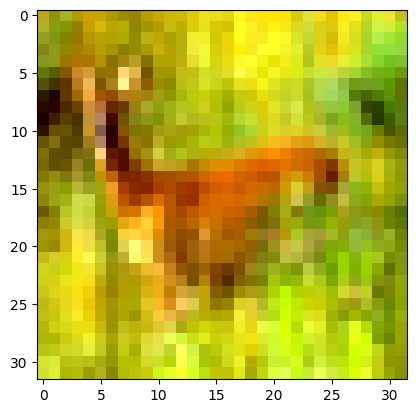

deer
Shape of one class instance:  torch.Size([3, 32, 32])


In [33]:
# Let's see how our data looks into our train set (Not required for the assignment)
img, label = train_ds[4]

imshow(img)
print(classes[label])
print("Shape of one class instance: ", img.shape)

2. Implement a fully connected FFNN (no CNN). Train for a few epochs.


In [34]:
## YOUR CODE GOES HERE
class FFNN(nn.Module):
  def __init__(self, hidden=512):
        super().__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, hidden)  # Input layer: 3*32*32 pixels
        self.fc2 = nn.Linear(hidden, 10)           # Output layer: 10 classes

  def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)              # Flatten the image
        x = F.relu(self.fc1(x))                 # Apply ReLU activation to hidden layer
        x = self.fc2(x)                         # Output layer
        return x


model = FFNN(hidden=512).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

3. Plot training vs validation loss and accuracy.


In [43]:
## YOUR CODE GOES HERE
# Create test dataloader
test_ds = datasets.CIFAR10(root, train=False, download=True, transform=train_tf)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Training loop
epochs = 12  # You can change the number of epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.3f}, Val Accuracy: {val_accuracy:.2f}%')

print('Finished Training')

Epoch 1, Train Loss: 0.457, Train Accuracy: 84.92%, Val Loss: 2.226, Val Accuracy: 50.96%
Epoch 2, Train Loss: 0.389, Train Accuracy: 87.26%, Val Loss: 2.283, Val Accuracy: 51.72%
Epoch 3, Train Loss: 0.378, Train Accuracy: 87.71%, Val Loss: 2.401, Val Accuracy: 50.78%
Epoch 4, Train Loss: 0.368, Train Accuracy: 87.74%, Val Loss: 2.406, Val Accuracy: 51.38%
Epoch 5, Train Loss: 0.382, Train Accuracy: 87.56%, Val Loss: 2.408, Val Accuracy: 51.64%
Epoch 6, Train Loss: 0.351, Train Accuracy: 88.68%, Val Loss: 2.526, Val Accuracy: 50.82%
Epoch 7, Train Loss: 0.333, Train Accuracy: 89.08%, Val Loss: 2.638, Val Accuracy: 50.18%
Epoch 8, Train Loss: 0.293, Train Accuracy: 90.53%, Val Loss: 2.728, Val Accuracy: 49.42%
Epoch 9, Train Loss: 0.318, Train Accuracy: 89.82%, Val Loss: 2.783, Val Accuracy: 49.34%
Epoch 10, Train Loss: 0.264, Train Accuracy: 91.50%, Val Loss: 2.682, Val Accuracy: 50.42%
Epoch 11, Train Loss: 0.245, Train Accuracy: 92.12%, Val Loss: 2.795, Val Accuracy: 50.96%
Epoch 12

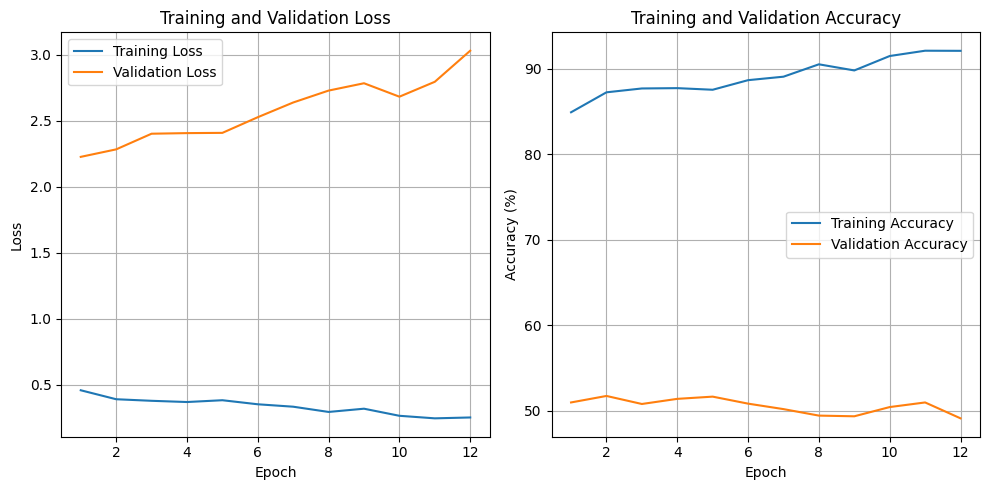

In [44]:
# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

4. Compute a confusion matrix on the validation set.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


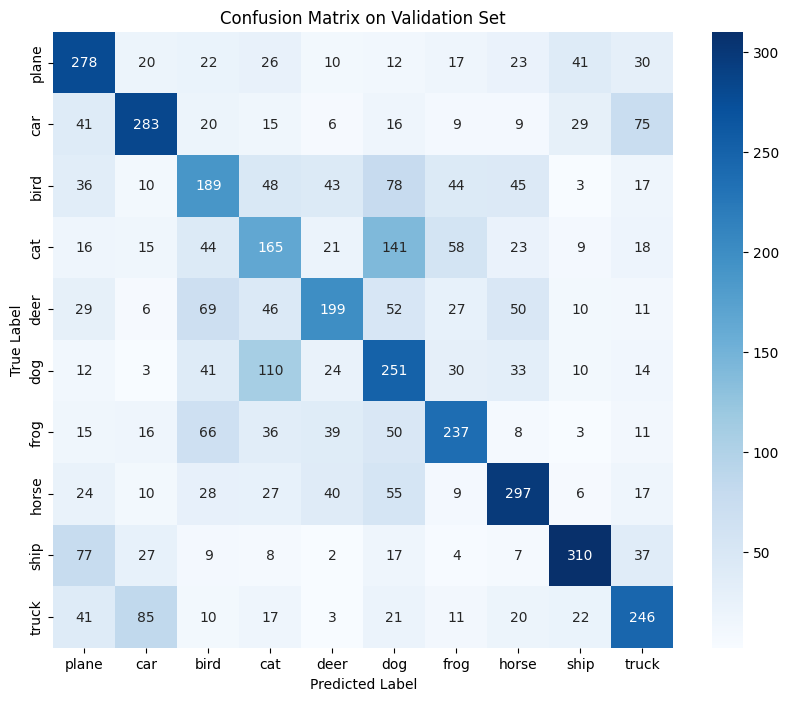


Metrics per class:
plane: Precision=0.4886, Recall=0.5804, F1 Score=0.5305
car: Precision=0.5958, Recall=0.5626, F1 Score=0.5787
bird: Precision=0.3795, Recall=0.3684, F1 Score=0.3739
cat: Precision=0.3313, Recall=0.3235, F1 Score=0.3274
deer: Precision=0.5142, Recall=0.3988, F1 Score=0.4492
dog: Precision=0.3622, Recall=0.4754, F1 Score=0.4111
frog: Precision=0.5314, Recall=0.4927, F1 Score=0.5113
horse: Precision=0.5767, Recall=0.5789, F1 Score=0.5778
ship: Precision=0.6998, Recall=0.6225, F1 Score=0.6589
truck: Precision=0.5168, Recall=0.5168, F1 Score=0.5168


In [46]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns

# Get predictions for the validation set
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Compute precision, recall, and F1 score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None, labels=np.arange(len(classes)))

print('\nMetrics per class:')
for i, class_name in enumerate(classes):
    print(f'{class_name}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1 Score={f1_score[i]:.4f}')

5. Display a grid of misclassified examples with predicted vs true labels.


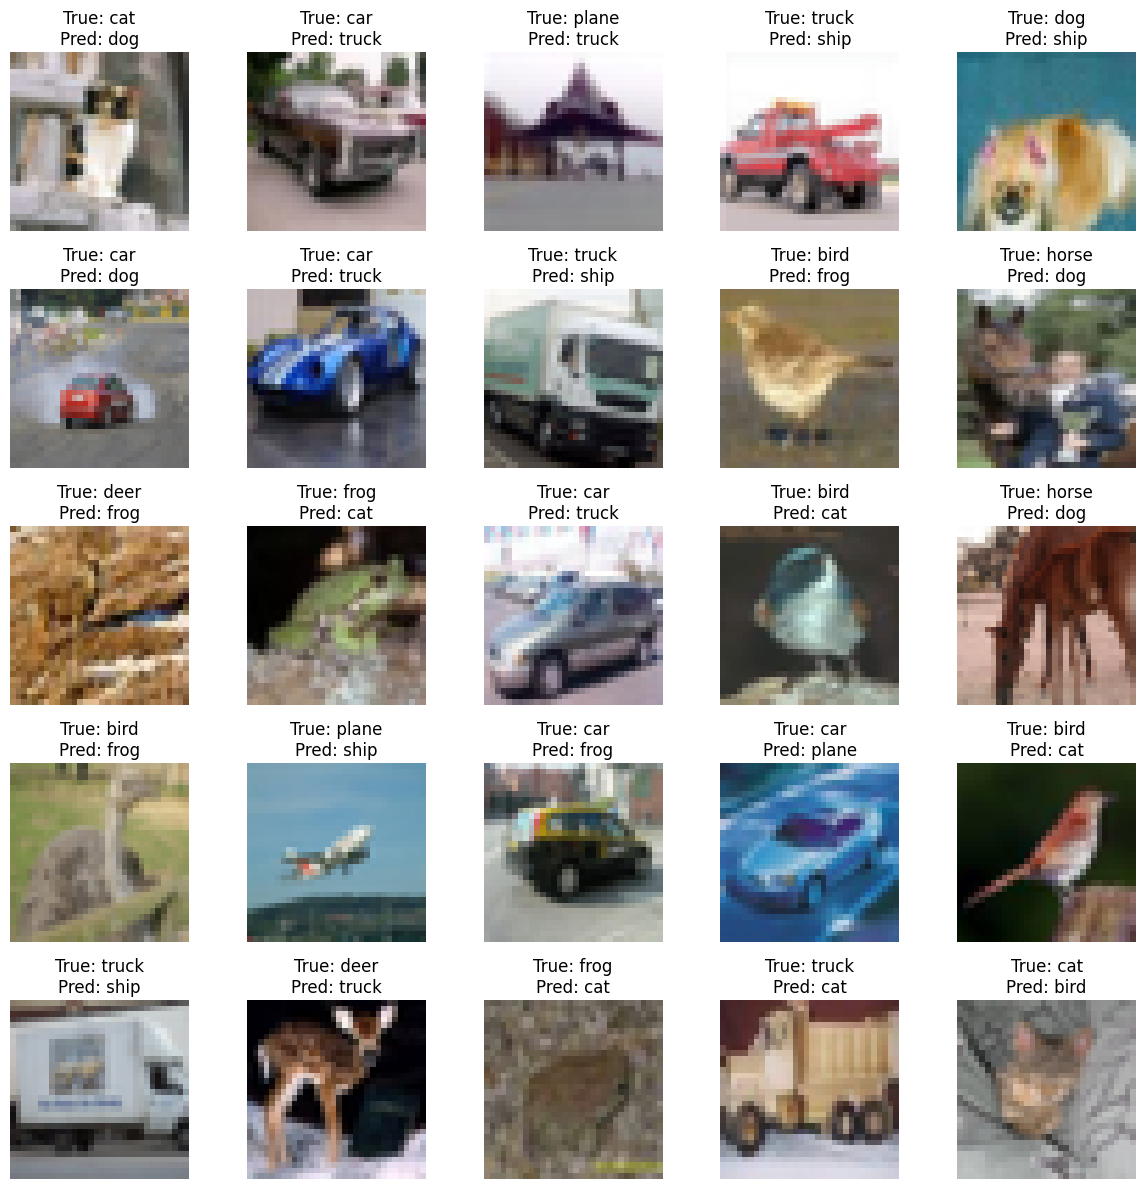

In [38]:
## YOUR CODE GOES HERE
# Get misclassified examples
misclassified_indices = [i for i in range(len(all_labels)) if all_labels[i] != all_predictions[i]]

# Display a grid of misclassified examples
plt.figure(figsize=(12, 12))
for i, idx in enumerate(misclassified_indices[:25]): # Displaying up to 25 misclassified images
    plt.subplot(5, 5, i + 1)
    # Unnormalize the image before displaying
    img = val_ds[idx][0] * torch.tensor(cifar_std).view(3, 1, 1) + torch.tensor(cifar_mean).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.imshow(npimg)
    plt.title(f'True: {classes[all_labels[idx]]}\nPred: {classes[all_predictions[idx]]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## PART B: Take Home

1. Make one or two changes to your hidden size / activation / learning rate / epochs


In [39]:
## YOUR CODE GOES HERE
# Define new hyperparameters
new_hidden_size = 1024
new_learning_rate = 0.0005

# Create a new model with the modified hyperparameters
new_model = FFNN(hidden=new_hidden_size).to(device)

# Define criterion and optimizer for the new model
new_criterion = nn.CrossEntropyLoss()
new_optimizer = torch.optim.Adam(new_model.parameters(), lr=new_learning_rate)

2. Re‑train and update plots & validation metrics.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1, Train Loss: 1.664, Train Accuracy: 42.23%, Val Loss: 1.546, Val Accuracy: 46.66%
Epoch 2, Train Loss: 1.426, Train Accuracy: 50.29%, Val Loss: 1.461, Val Accuracy: 49.00%
Epoch 3, Train Loss: 1.311, Train Accuracy: 54.62%, Val Loss: 1.455, Val Accuracy: 49.28%
Epoch 4, Train Loss: 1.245, Train Accuracy: 56.89%, Val Loss: 1.450, Val Accuracy: 51.16%
Epoch 5, Train Loss: 1.163, Train Accuracy: 60.09%, Val Loss: 1.434, Val Accuracy: 51.44%
Epoch 6, Train Loss: 1.096, Train Accuracy: 61.99%, Val Loss: 1.445, Val Accuracy: 50.96%
Epoch 7, Train Loss: 1.022, Train Accuracy: 64.77%, Val Loss: 1.460, Val Accuracy: 52.02%
Epoch 8, Train Loss: 0.974, Train Accuracy: 66.50%, Val Loss: 1.491, Val Accuracy: 50.66%
Epoch 9, Train Loss: 0.902, Train Accuracy: 69.01%, Val Loss: 1.506, Val Accuracy: 51.94%
Epoch 10, Train Loss: 0.854, Train Accuracy: 71.03%, Val Loss: 1.489, Val Accuracy: 53.30%
Finished Training with new hyperparameters


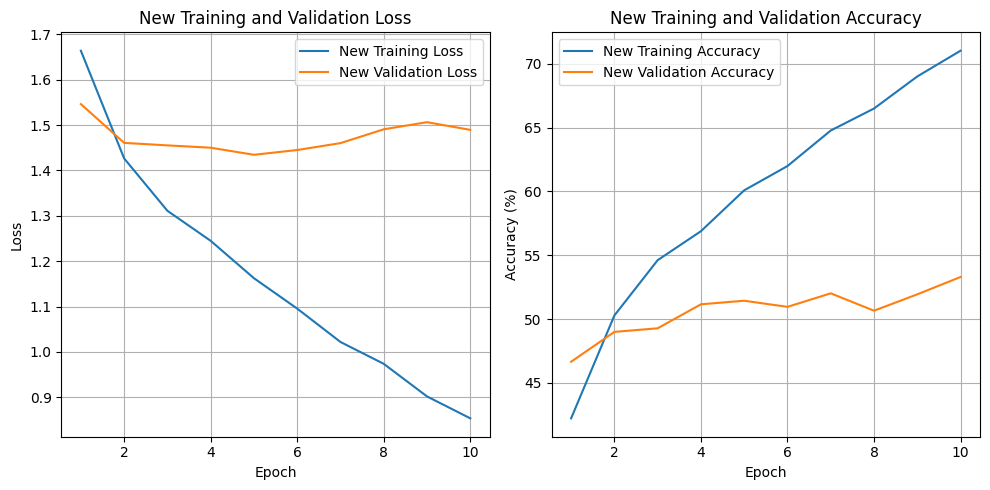

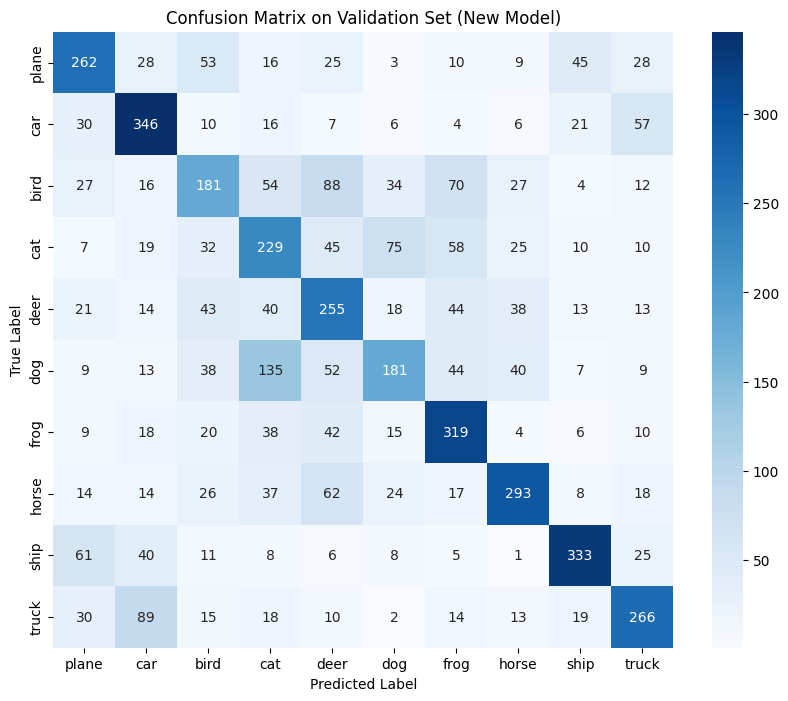

In [40]:
## YOUR CODE GOES HERE
epochs = 10

new_train_losses = []
new_val_losses = []
new_train_accuracies = []
new_val_accuracies = []

for epoch in range(epochs):
    new_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        new_optimizer.zero_grad()

        outputs = new_model(inputs)
        loss = new_criterion(outputs, labels)
        loss.backward()
        new_optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    new_train_losses.append(train_loss)
    new_train_accuracies.append(train_accuracy)

    # Validation
    new_model.eval()
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = new_model(images)
            loss = new_criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    new_val_losses.append(val_loss)
    new_val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.3f}, Val Accuracy: {val_accuracy:.2f}%')

print('Finished Training with new hyperparameters')

# Plotting with new results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), new_train_losses, label='New Training Loss')
plt.plot(range(1, epochs + 1), new_val_losses, label='New Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('New Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), new_train_accuracies, label='New Training Accuracy')
plt.plot(range(1, epochs + 1), new_val_accuracies, label='New Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('New Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Compute and display confusion matrix for the new model
new_all_labels = []
new_all_predictions = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, 1)
        new_all_labels.extend(labels.cpu().numpy())
        new_all_predictions.extend(predicted.cpu().numpy())

new_cm = confusion_matrix(new_all_labels, new_all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(new_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Validation Set (New Model)')
plt.show()

3. Write a 1–2 page PDF discussing training dynamics, confusion trends, and effect of your changes. DONT FORGET TO SUBMIT PDF.